# Getting matches

### Importing libraries

In [98]:
from helpers.setup import parse_config_file
import sys
import numpy as np
import time

from sklearn.decomposition import PCA
from scipy import io
from scipy.spatial.distance import cdist

import cv2 
from cv2 import DMatch

import matplotlib.pyplot as plt

### Getting features from video

This function implements the SIFT algorithm to find keypoints of the image

In [99]:
def get_features(vid_capture, frames_to_process):
    features = np.zeros((1, frames_to_process), dtype=object)
    frames = []
    keypoints_array = []
    current_frame = 0 
    while(vid_capture.isOpened()):
        # vid_capture.read() methods returns a tuple, first element is a bool 
        # and the second is frame
        for _ in range(100):
            ret, frame = vid_capture.read()
            
        sift = cv2.SIFT_create()
        if ret == True:
            # getting keypoints and descriptor
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            keypoints, descriptor = sift.detectAndCompute(frame_gray, None)
            keypoints_array.append(keypoints)

            # getting the location of each keypoint
            x_location = []
            y_location = []
            for keypoint in keypoints:
                x_location.append(keypoint.pt[0])
                y_location.append(keypoint.pt[1])
            ## (x, y, d)
            concatenation = np.insert(np.transpose(descriptor), [0, 1], [x_location, y_location], axis=0)
            #print(f'concatenation: {np.shape(concatenation)}') 
            features[0, current_frame] = concatenation

            current_frame += 1
            frames.append(frame)
            static_frame = cv2.drawKeypoints(frame, keypoints, None, color=(0, 255, 0))
            cv2.imshow('Static Keypoints', static_frame)
            
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

            if current_frame == frames_to_process:
                break
        else:
            break
    # print(features.shape)
    vid_capture.release()
    cv2.destroyAllWindows()
    return features, frames, keypoints_array

### Finding matches from keypoint descriptors from two images

In [100]:
def match_features(features1, features2, matches_size = 100, num_features= 64):
    C = np.vstack((features1, features2))
    
    # PCA
    pca = PCA(n_components=num_features)
    reconstructed = pca.fit_transform(C)
    
    features1 = reconstructed[:len(features1), :]
    features2 = reconstructed[len(features1):, :]
    
    # Euclidean distance
    D = cdist(features1, features2, 'euclidean')
    
    # Sorting distances and finding nearest neighbors
    I = np.argsort(D, axis=1)
    nearest_neighbor = D[np.arange(len(D)), I[:, 0]]
    second_nearest_neighbor = D[np.arange(len(D)), I[:, 1]]
    confidences = nearest_neighbor / second_nearest_neighbor
    
    # Filtering non-zero confidences
    i = np.where(confidences)[0]
    matches = np.column_stack((i, I[i]))
    confidences = 1.0 / confidences[i]
    
    # Sorting by confidence and selecting top 100 matches
    sorted_indices = np.argsort(confidences)[::-1]
    matches = matches[sorted_indices][:matches_size, :]
    confidences = confidences[sorted_indices][:matches_size]

    matches = [DMatch(_queryIdx=int(match[0]), 
                      _trainIdx=int(match[1]), 
                      _distance=float(D[int(match[0]), int(match[1])])) 
                          for match in matches]
    
    return matches, confidences

### `processing_video.py` main

In [101]:
config_path = "./conf_file.cpg"
config = parse_config_file(config_path)

vid_capture = cv2.VideoCapture(config['videos'])
frames_to_process = 5

features, frames, keypoints_array = get_features(vid_capture, frames_to_process)

### Save dict for further analysis

In [102]:
def save_matches(features, frames_to_process):
    matches_dict = {}
    for i in range(frames_to_process):
        for j in range(i+1, frames_to_process):
            matches, confidences = match_features(np.transpose(features[0, i][2:]), np.transpose(features[0, j][2:]), matches_size=100)
            matches_dict[(i, j)] = matches
    return matches_dict
matches_dict = save_matches(features, 5)

# Improving homography

In [103]:
dict_for_debug = {
    'matches': matches_dict,
    'features': features,
    'frames': frames,
    'keypoints_array': keypoints_array,
}

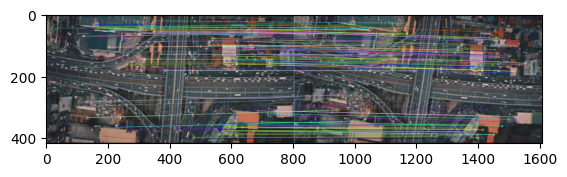

In [129]:
i, j = 1, 3
matches = dict_for_debug['matches'][(i, j)]
matched_img = cv2.drawMatches(frames[i], keypoints_array[i], frames[j], keypoints_array[j], matches_dict[(i, j)], None, flags=2)
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))

In [130]:
# Extract location of good matches
src_points = np.zeros((len(matches), 2), dtype=np.float32)
dst_points = np.zeros_like(points1)

for k, match in enumerate(matches):
    points1[k, :] = keypoints_array[i][match.queryIdx].pt
    points2[k, :] = keypoints_array[j][match.trainIdx].pt

In [131]:
def create_homography_matrix(src_points, dst_points):
    A = []
    b = [] 
    for i in range(len(src_points)):
        x, y = src_points[i]
        u, v = dst_points[i]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y])

        b.append(u)
        b.append(v)

    A = np.array(A)

    h = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)), b)
    h = np.append(h, 1) 
    h = h.reshape(3,3)
    
    return h

[[ 1.05622805e+00  7.93116605e-02 -4.12612317e+01]
 [-7.94363743e-02  1.05434988e+00  1.94570536e+01]
 [ 3.08907863e-06 -5.73778396e-06  1.00000000e+00]]
[[ 1.05593345e+00  7.91445921e-02 -4.11937478e+01]
 [-7.94590948e-02  1.05406272e+00  1.94814832e+01]
 [ 2.81559203e-06 -6.05922123e-06  1.00000000e+00]]


(-0.5, 803.5, 415.5, -0.5)

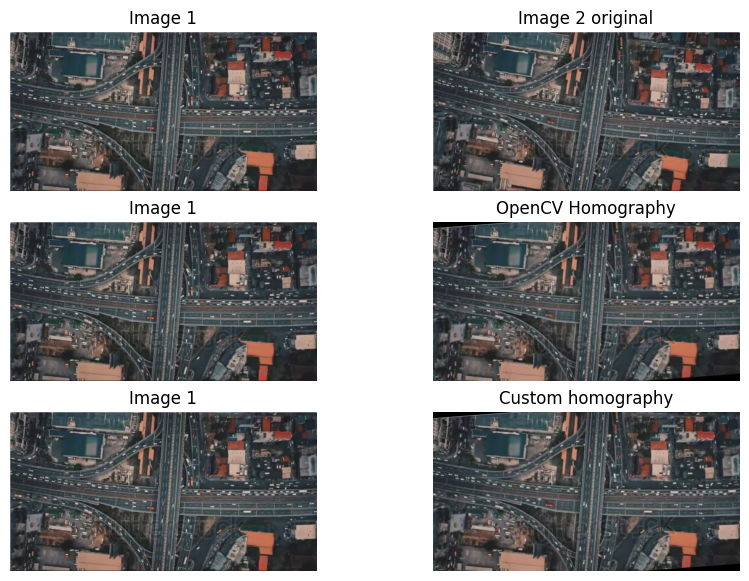

In [133]:
H, mask = cv2.findHomography(points2, points1)
print(H)
height, width, channels = frames[i].shape
output = cv2.warpPerspective(frames[j], H, (width, height))

fig, ax = plt.subplots(3, 2, figsize=(10, 7))
ax[0][0].imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
ax[0][0].set_title('Image 1')
ax[0][0].axis('off')

ax[0][1].imshow(cv2.cvtColor(frames[j], cv2.COLOR_BGR2RGB))
ax[0][1].set_title('Image 2 original')
ax[0][1].axis('off')


ax[1][0].imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
ax[1][0].set_title('Image 1')
ax[1][0].axis('off')

ax[1][1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
ax[1][1].set_title('OpenCV Homography')
ax[1][1].axis('off')

H = create_homography_matrix(points2, points1)
print(H)
height, width, channels = frames[i].shape
output = cv2.warpPerspective(frames[j], H, (width, height))

ax[2][0].imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
ax[2][0].set_title('Image 1')
ax[2][0].axis('off')

ax[2][1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
ax[2][1].set_title('Custom homography')
ax[2][1].axis('off')